# Preprocess snATAC-seq

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import remove_black_list_region, significant_pc_test, binarize_matrix, filter_regions, lsi
from ALLCools.plot import *

## Load data

- 5Kb bins raw counts matrix from snATAC-seq

In [2]:
adata = anndata.read_h5ad('../../input/snATAC.5kb.Neuron.h5ad')

## Run Intra-dataset Clustering

### Binarize and LSI
- These functions are taken from the mCG-5Kb clustering, which is very similar to the snATAC analysis
- You may also use the snATAC analysis packages (e.g., snapatac, signac) to process the snATAC data and get the PCs and cluster labels

In [3]:
binarize_matrix(adata)

filter_regions(adata, hypo_cutoff=300)

black_list_path = None  # already removed black list regions
if black_list_path is not None:
    remove_black_list_region(adata, black_list_path, f=0.1)
adata

AnnData object with n_obs × n_vars = 43361 × 185431
    obs: 'MajorType', 'SubType'

In [4]:
lsi(adata, algorithm='arpack', obsm='X_pca')

# choose significant components
n_components = significant_pc_test(adata)

33 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (43361, 100) to (43361, 33)


In [5]:
# remove first PC as it is highly correlated with coverage
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 1:]
n_components -= 1

### Check the PCs

Red axis labels are used PCs


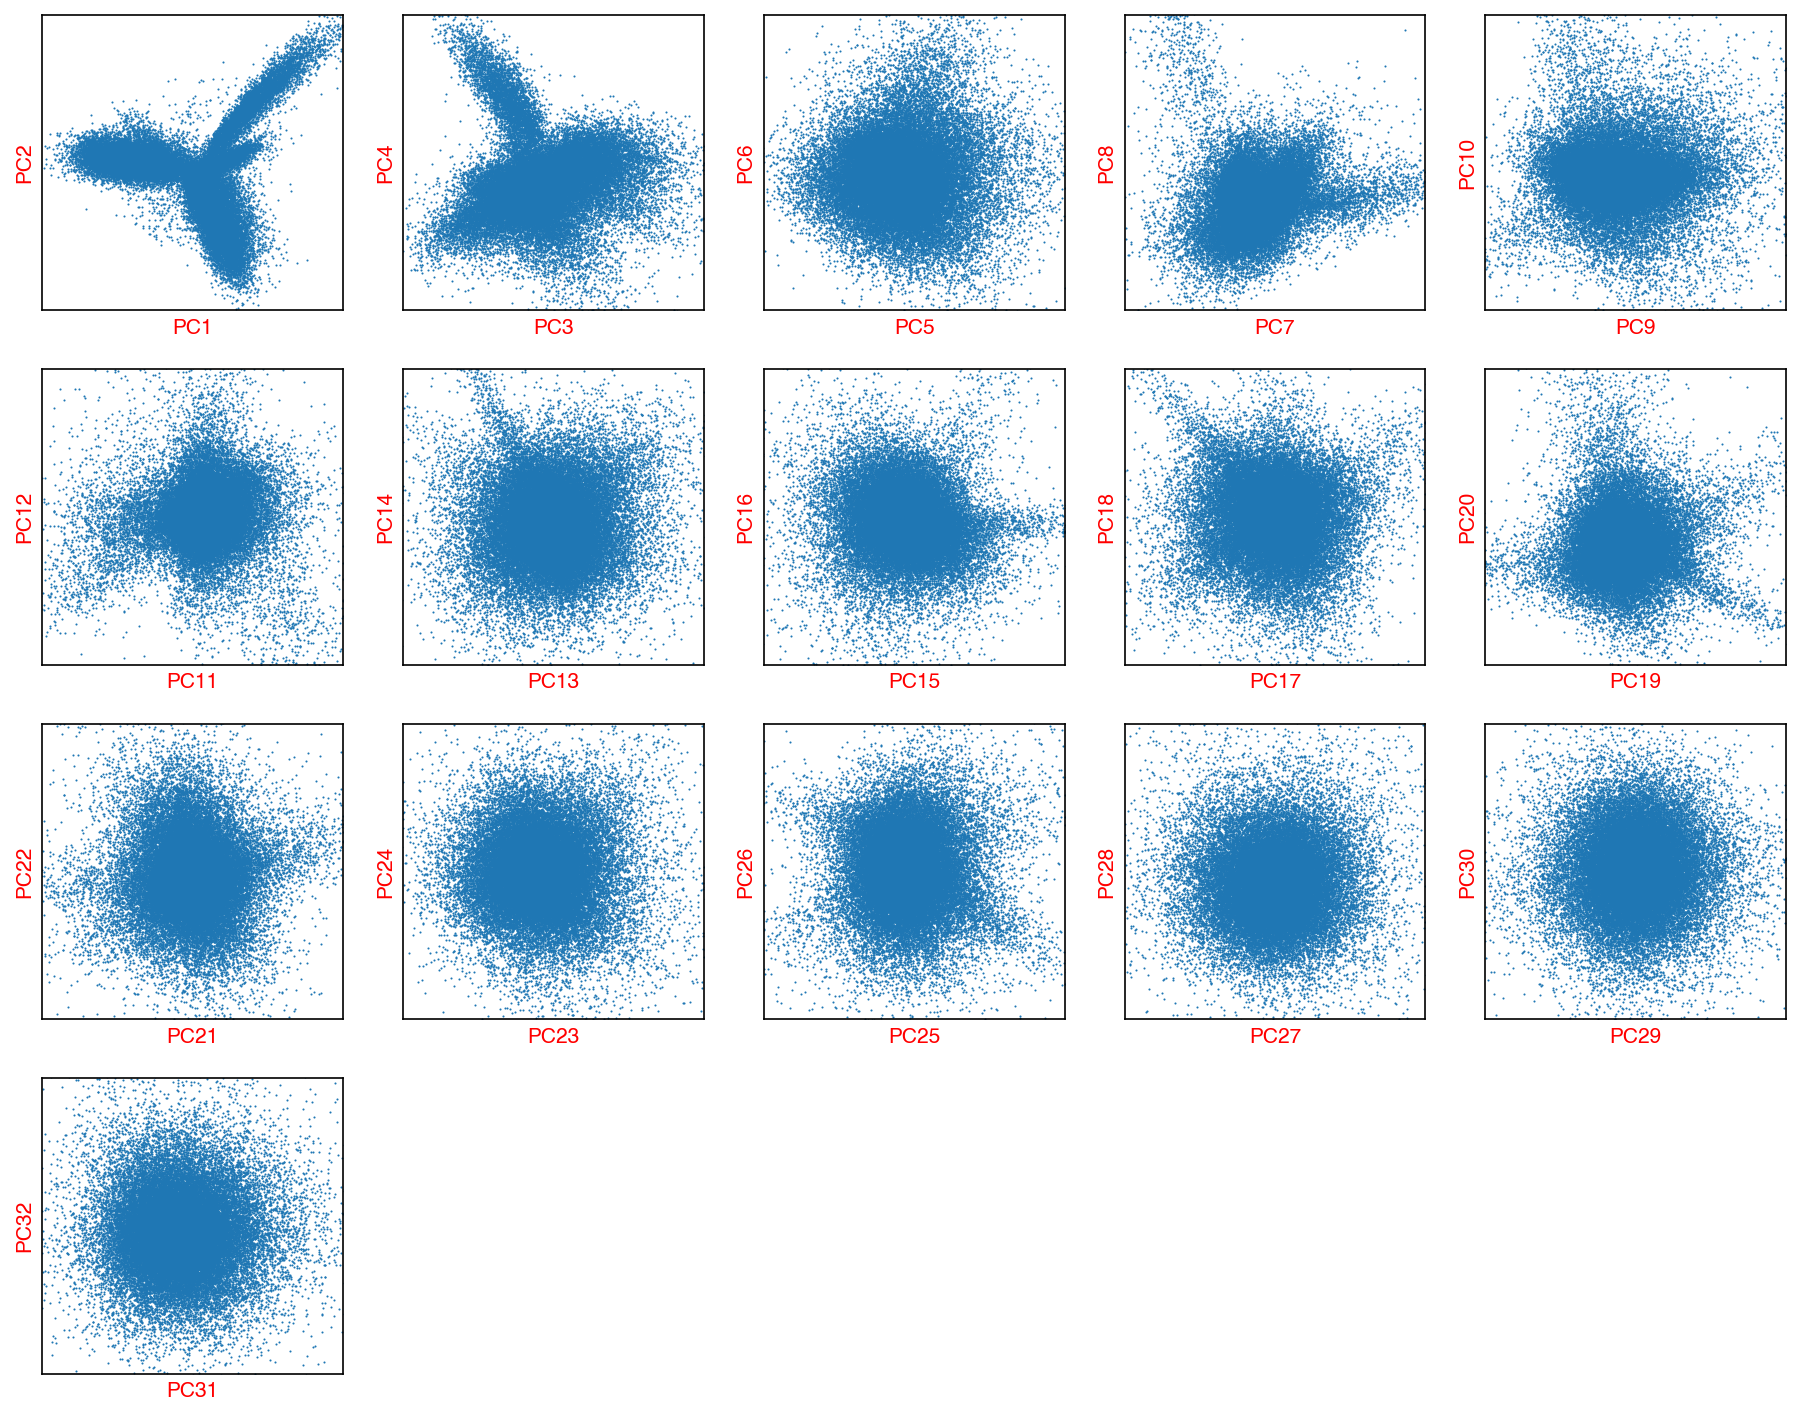

In [6]:
fig, axes = plot_decomp_scatters(adata,
                                 n_components=n_components,
                                 hue=None,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=5,
                                 ncols=5)

### Leiden clustering

In [7]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [8]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata)
dump_embedding(adata, 'umap')

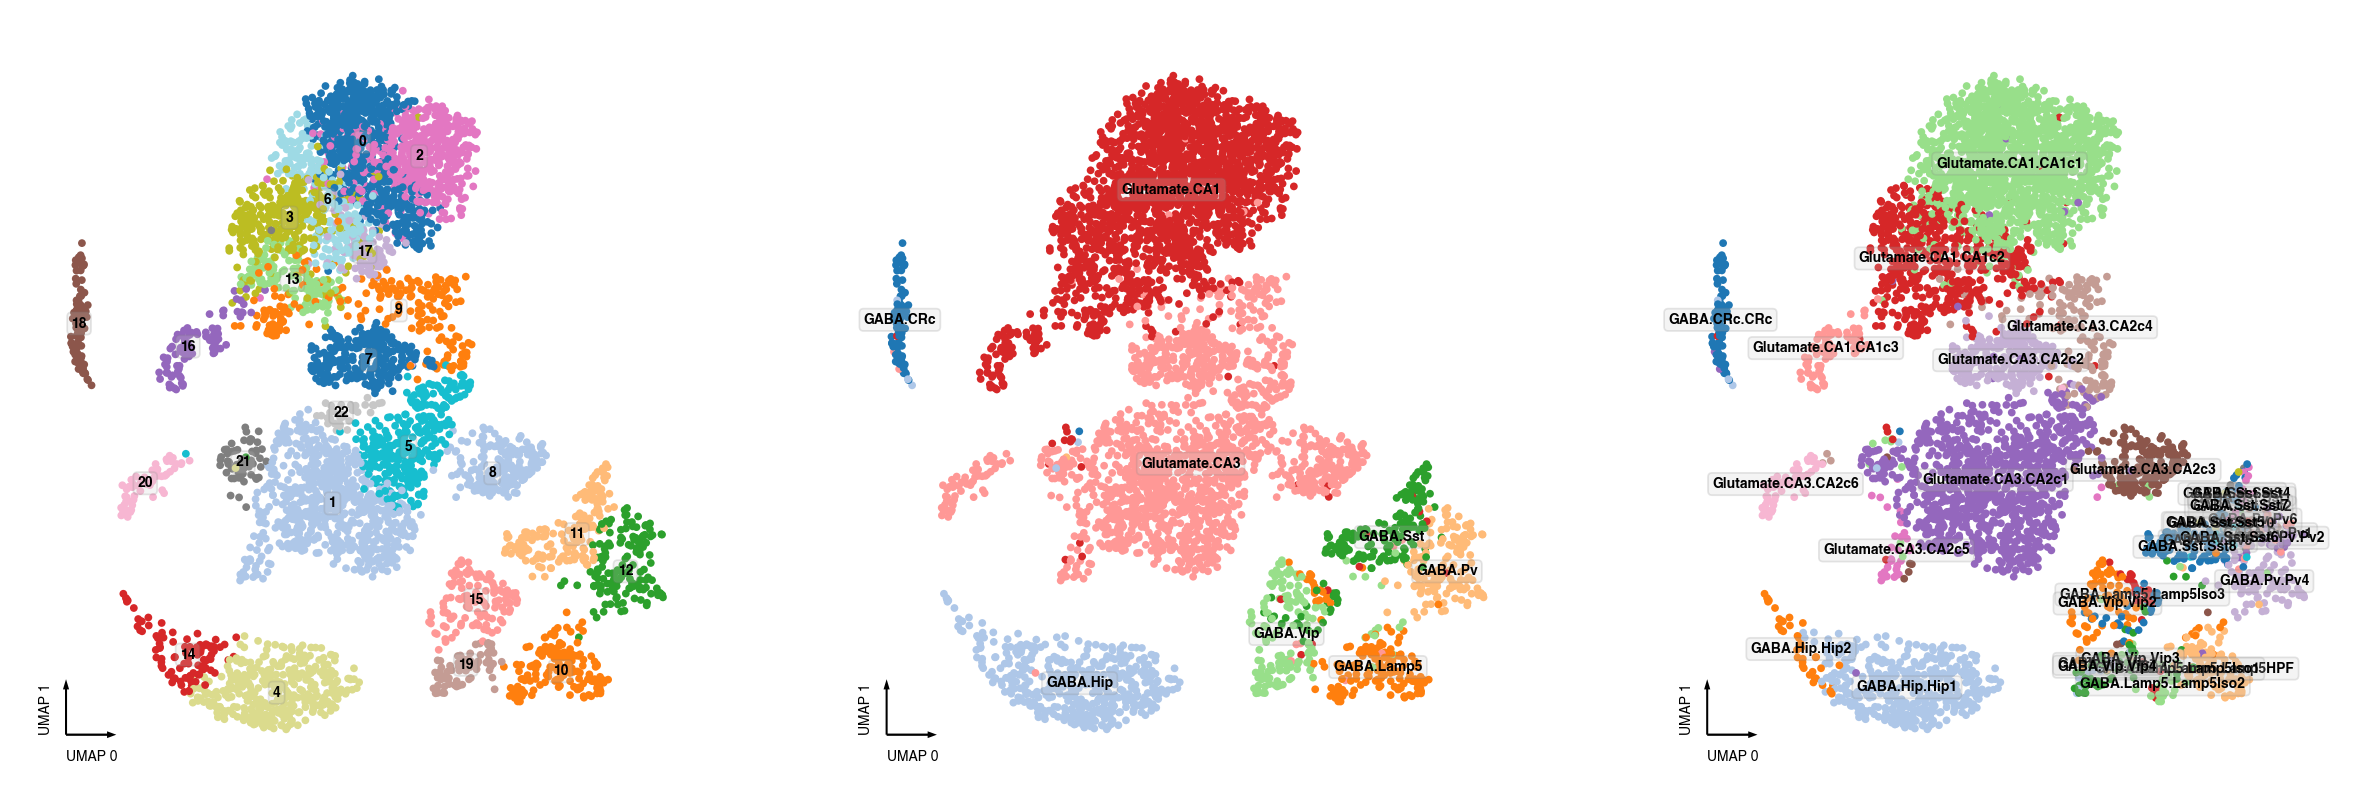

In [9]:
fig, axes = plt.subplots(figsize=(12, 4), dpi=250, ncols=3)
adata.obs['SubType'] = adata.obs['SubType'].astype(str)
adata.obs['MajorType'] = adata.obs['MajorType'].astype(str)

ax = axes[0]
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        palette='tab20',
                        text_anno='leiden')
ax = axes[1]
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='MajorType',
                        palette='tab20',
                        text_anno='MajorType')
ax = axes[2]
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='SubType',
                        palette='tab20',
                        text_anno='SubType')

### Downsample and balance each cluster
In this step, we group the `obsm` matrix by `cluster_col`, and run K-means on each cluster's matrix. For large clusters that have > `cluster_size_cutoff` number of cells, the K-means clustering is done iteratively until all the clusters are smaller than `max_pseudo_size`. The reducing function `aggregate_func` can be:
- `sum`: if the `adata.X` is raw counts matrix and you want to add them together to form a pseudo-cell
- `mean`: take the mean of each K-means cell group
- `median`: take the mean of each K-means cell group
- `downsample`: randomly select only one cell from the K-means cell group.

Notes:
- Here I used the cluster labels generated by the data provider, which is more granular than the leiden clusters because these labels are calculated with other brain datasets in a iterative process.
- If such labels don't exist, you may use just the leiden clusters above

In [10]:
gene_adata = anndata.read_h5ad('../../input/snATAC.gene.Neuron.h5ad')

- We use 5Kb bin matrix to calculate PCs and identify cell groups
- We use gene matrix to generate pseudo-cells in order to integrate with other modalities.

In [11]:
# add bins PCs to gene adata
gene_adata.obsm['X_pca'] = adata.obsm['X_pca']
gene_adata.obs['SubType'] = adata.obs['SubType']
gene_adata.obs['MajorType'] = adata.obs['MajorType']

In [12]:
from ALLCools.pseudo_cell import generate_pseudo_cells_kmeans

pseudo_adata = generate_pseudo_cells_kmeans(gene_adata,
                                            cluster_col='SubType',
                                            obsm='X_pca',
                                            cluster_size_cutoff=100,
                                            max_pseudo_size=50,
                                            aggregate_func='downsample')

pseudo_adata

AnnData object with n_obs × n_vars = 5026 × 53278
    obs: 'n_cells', 'SubType'

## Identify HVF for integration

In [13]:
# remove low cov gene
sc.pp.filter_genes(gene_adata, min_cells=int(gene_adata.shape[0] * 0.003))
sc.pp.normalize_per_cell(gene_adata)
sc.pp.log1p(gene_adata)

In [14]:
pseudo_adata = pseudo_adata[:, gene_adata.var_names]
sc.pp.normalize_per_cell(pseudo_adata)
sc.pp.log1p(pseudo_adata)

Trying to set attribute `.obs` of view, copying.


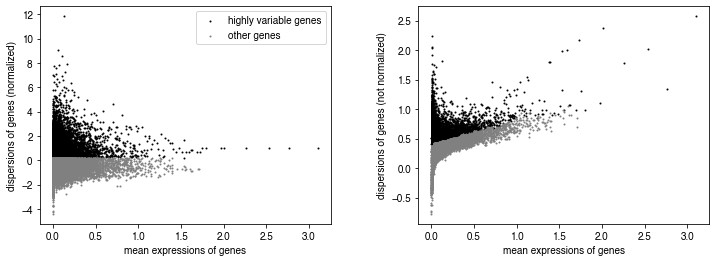

In [15]:
# identify highly variable genes on pseudo_adata
sc.pp.highly_variable_genes(pseudo_adata, n_top_genes=10000, n_bins=100)
sc.pl.highly_variable_genes(pseudo_adata)
test_adata = pseudo_adata[:, pseudo_adata.var['highly_variable']].copy()

## Save AnnData

In [16]:
gene_adata.write_h5ad(f'ATAC.TotalAdata.norm_log1p.h5ad')

... storing 'MajorType' as categorical
... storing 'SubType' as categorical
... storing 'pseudo_group' as categorical


In [17]:
pseudo_adata.write_h5ad(f'ATAC.PseudoCellAdata.norm_log1p.h5ad')

... storing 'SubType' as categorical


## Run a test clustering with HVFs
Run a test clustering within this dataset to check how diverse the HVF matrix is.

In [18]:
sc.pp.scale(test_adata)
sc.tl.pca(test_adata)
sc.pp.neighbors(test_adata)
sc.tl.umap(test_adata)
sc.tl.leiden(test_adata)
test_adata.obs['group'] = test_adata.obs_names.map(lambda i: '.'.join(i.split('.')[:2]))

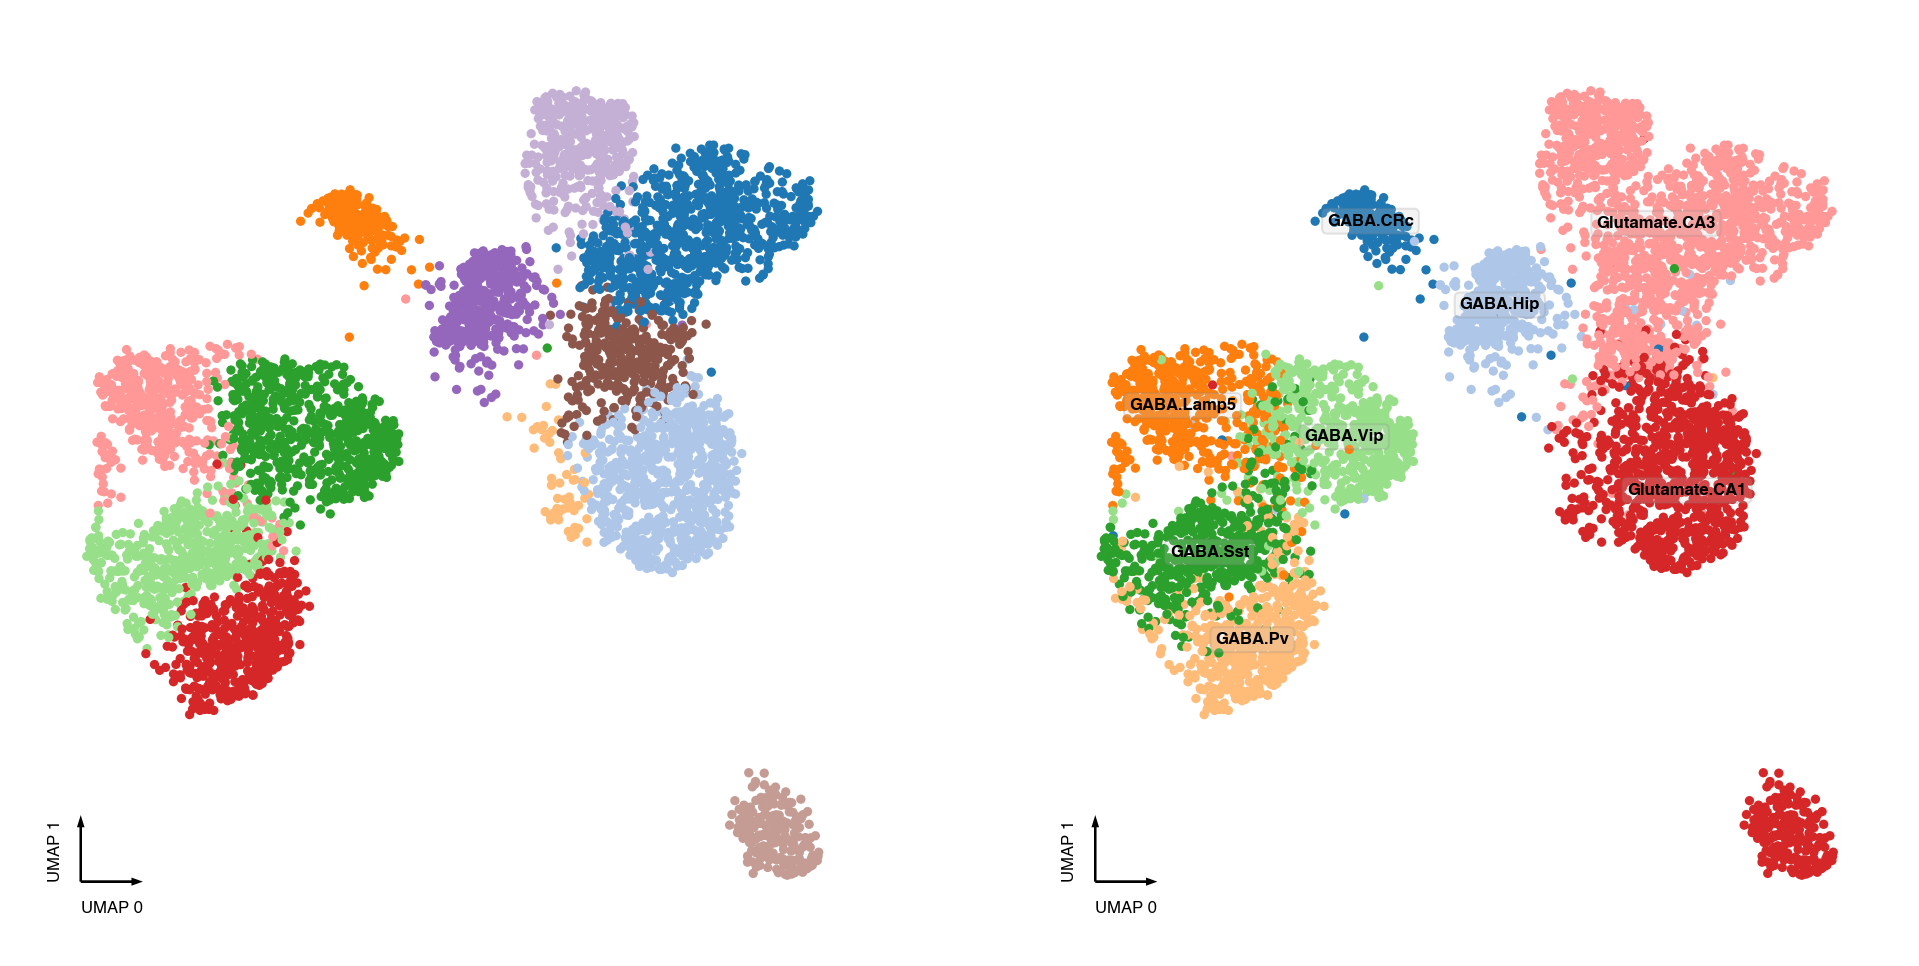

In [26]:
fig, axes = plt.subplots(figsize=(8, 4), dpi=300, ncols=2)
ax = axes[0]
categorical_scatter(ax=ax, data=test_adata, hue='leiden', palette='tab20')
ax = axes[1]
test_adata.obs['MajorType'] = test_adata.obs['SubType'].apply(
    lambda i: '.'.join(i.split('.')[:2]))
categorical_scatter(ax=ax, data=test_adata, hue='MajorType', palette='tab20', text_anno='MajorType')